In [211]:
%matplotlib nbagg
import matplotlib.pyplot as plt
import numpy as np
import pandas_datareader as web
from scipy import stats
from sklearn.neighbors.kde import KernelDensity
from scipy.signal import argrelmax,argrelmin
from multiprocessing import Pool
import datetime as dt
import util
import pandas as pd
import seaborn as sns; sns.set()
import pprint
import functools
import math

In [210]:
symbols = pd.read_csv('data/SP500.csv',  usecols=['Symbol', 'Sector'])
sectors = set(symbols.to_dict(orient='list')['Sector'])
d = [(key,value) for (key, value) in symbols.to_dict(orient='split')['data']]
pprint.pprint(sectors)
d.remove(('FTV','Industrials'))
d.remove(('LMT','Industrials'))
d.remove(('NLSN','Industrials'))
d.remove(('CHTR','Consumer Discretionary'))
d.remove(('NWL','Consumer Discretionary'))
d.remove(('UA','Consumer Discretionary'))
d.remove(('KHC','Consumer Staples'))
d.remove(('EVHC','Health Care'))
d.remove(('WRK','Materials'))
d.remove(('AVGO','Information Technology'))
d.remove(('CSRA','Information Technology'))
d.remove(('DXC','Information Technology'))
d.remove(('HPE','Information Technology'))
d.remove(('PYPL','Information Technology'))
d.remove(('AMT','Real Estate'))
d.remove(('NBL','Energy'))
d.remove(('FTI','Energy'))
d.remove(('XL','Financials'))

set(['Consumer Discretionary',
     'Consumer Staples',
     'Energy',
     'Financials',
     'Health Care',
     'Industrials',
     'Information Technology',
     'Materials',
     'Real Estate',
     'Telecommunication Services',
     'Utilities'])


In [209]:
def profitmap(year,df):
    A=np.zeros( (252,252) )
    for x in range(0,252):
        for y in range(0,252):
            sd = dt.date(year,1,1)+dt.timedelta(x)
            ed = dt.date(year,1,1)+dt.timedelta(y)
            if y<x:
                ed = dt.date(year,1,1)+dt.timedelta(y+365)
            if sd in df.index and ed in df.index:
                A[x][y]=(df.loc[ed]/df.loc[sd]) -1
    return A


def profitmap2(year,df):
    sy = dt.date(year,1,1)
    data = df[sy:]
    A=np.zeros( (252,252))
    for x in range(0,252):
        for y in range(0,252):
            si = x
            ei = si + y
            A[x,y]=(data.ix[ei]/data.ix[si]) -1
    return A

def profitmap3(year,df,maplen=150):
    sy= dt.date(year,1,1)
    data = df[sy:]
    A=np.zeros( (252,maplen) )
    for x in range(0,252):
        vector = data.iloc[x:x+252]
        A[x,] = np.reshape((np.array((vector / vector.iloc[0]) -1)[:maplen]),(maplen,))
    return A

def profit_density(profit_map,min_ret=0.1,max_ret=1.0):
    density_map = list()
    for row in range(0,252):
        a = profit_map[row]
        x= np.linspace(a.min(),a.max(), num=252)
        kernel = stats.gaussian_kde(a)
        density_map.append(kernel.integrate_box_1d(min_ret,max_ret))
    return density_map

def pm_backtest(df,start_year,enter,exit,maplen=150,debug=0):
    returns =[]
    for year in range (start_year,2017):
        if debug: print year
        sy = dt.date(year,1,1)
        data = df[sy:]
        buy = data.iloc[enter]
        if debug: print "Buy @ %0.2f on %s"%(buy,buy.name)
        pot_returns = data.iloc[enter:] / data.iloc[enter]
        sell_dates = filter(lambda x: x[1][0] > exit, pot_returns[:maplen].iterrows())
        if len(sell_dates)>0:
            exit_date = sell_dates[0]
        else:
            exit_date= list(pot_returns[:maplen].iterrows())[-1]
        
        sell = data.loc[exit_date[0]]
        if debug: print "Sell @ %f on %s"%(sell,sell.name) 
        if debug: print "Profit %f in %s: %f/share : %f%%"%(sell-buy,sell.name - buy.name, sell-buy, 100*(sell/buy-1))
        returns.append(float(sell/buy)-1)
    return returns

In [3]:
sd = dt.date(2005,1,1)
ed = dt.date(2017,12,31)

In [ ]:
p=Pool(5)
promaps = {}
for sector in list(sectors):
    print sector
    syms = map(lambda x: x[0], filter(lambda x: x[1] == sector, d))
    sym_maps = []
    for sym in syms:
        print sym
        df = pd.DataFrame(web.DataReader(sym, 'google', sd, ed)['Close'])
        maps = p.map(functools.partial( profitmap3, df=df) ,range(2005,2015))
        m=np.hstack(maps)
        sym_maps.append(m)
    promaps[sector]=np.hstack(sym_maps)

In [ ]:
fig, ax = plt.subplots()
for sector in list(sectors)[:5]:
    ax.plot(profit_density(promaps[sector],0.05,5), label=sector)
plt.legend()
plt.show()
fig, ax = plt.subplots()
for sector in list(sectors)[5:]:
    ax.plot(profit_density(promaps[sector],0.05,5), label=sector)
plt.legend()
plt.show()

In [ ]:
C=np.hstack(sym_maps)
print C.shape
fig, ax = plt.subplots()
for x in np.linspace(0.05, 0.25,5 ):
    ax.plot(profit_density(C,x,5), label="%0.2f"%x)
ax.plot(profit_density(C,-1,0), label="loss")
plt.legend()
plt.show()

In [ ]:
D=np.array(profit_density(C,0.05,5))
print D.mean()
print D.std()
s=  D.mean() +D.std()
D > s

In [130]:
year = 2016
sy = dt.date(year,1,1)          
data = df[sy:]
print data.ix[178]

Close    31.08
Name: 2016-09-16 00:00:00, dtype: float64


C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [222]:
t={}
t.has_key(5)

False

In [232]:
sd = dt.date(2002,1,1)
ed = dt.date(2017,12,31)

profit_calendar={}
for sym,sector in d:
    try:
        print "Symbol: %s, Sector: %s"%(sym,sector)
        df = pd.DataFrame(web.DataReader(sym, 'yahoo', sd, ed)['Close'])
        C=np.hstack( map(lambda x: profitmap3(x,df,63) ,range(2002,2013)))
        q=np.array(profit_density(C,-1,0))
        enter_dates = map(lambda x: int(x), filter(lambda x: q[x] < 0.25, np.nditer(argrelmin(q, order=21))))
        for enter_date in enter_dates:
            bt= pm_backtest(df,2005,enter_date,1.15,63)
            if len(bt): print "Enter Date: %d,  Profit: %0.2f, Avg Profit: %0.2f"%(enter_date,sum(bt),sum(bt)/len(bt))
            if (sum(bt)/len(bt) >= 0.1) and ( sum(bt)/len(bt) < 0.5):
                #Add to Calendar
                print "Adding %s to calendar on %d"%(sym,enter_date)
                if not profit_calendar.has_key(enter_date): profit_calendar[enter_date]=list()
                profit_calendar[enter_date].append(sym)
    except Exception, e:
        print e
    
        
    

Symbol: AAP, Sector: Consumer Discretionary
Enter Date: 34,  Profit: 0.69, Avg Profit: 0.06
Enter Date: 200,  Profit: 1.19, Avg Profit: 0.10
Symbol: AMZN, Sector: Consumer Discretionary
Enter Date: 49,  Profit: 1.11, Avg Profit: 0.09
Enter Date: 152,  Profit: 0.67, Avg Profit: 0.06
Symbol: AN, Sector: Consumer Discretionary
Enter Date: 50,  Profit: 0.65, Avg Profit: 0.05
Symbol: AZO, Sector: Consumer Discretionary
Enter Date: 16,  Profit: 0.92, Avg Profit: 0.08
Enter Date: 49,  Profit: 0.40, Avg Profit: 0.03
Symbol: BBBY, Sector: Consumer Discretionary
Enter Date: 47,  Profit: 0.57, Avg Profit: 0.05
Symbol: BBY, Sector: Consumer Discretionary
Symbol: BWA, Sector: Consumer Discretionary
Enter Date: 224,  Profit: 1.02, Avg Profit: 0.09
Symbol: KMX, Sector: Consumer Discretionary
Symbol: CCL, Sector: Consumer Discretionary
Enter Date: 170,  Profit: 0.60, Avg Profit: 0.05
Symbol: CBS, Sector: Consumer Discretionary
Enter Date: 67,  Profit: 0.51, Avg Profit: 0.04
Enter Date: 224,  Profit: 1

In [233]:
profit_calendar

{2: ['HCA'],
 4: ['ORLY'],
 5: ['DLPH', 'HOLX'],
 11: ['TSCO', 'TRIP'],
 12: ['SYF', 'NFLX'],
 13: ['CXO', 'VLO'],
 14: ['CMG'],
 15: ['WYN'],
 16: ['GPS', 'RRC'],
 17: ['NWSA', 'NWS', 'CFG', 'LYB'],
 18: ['KSS', 'PXD', 'FLS', 'V'],
 19: ['HBI', 'FBHS'],
 23: ['VFC'],
 24: ['PCLN', 'MRO'],
 26: ['IR', 'IT'],
 27: ['TMK'],
 28: ['DG', 'KORS'],
 29: ['DLPH', 'ABBV'],
 32: ['NAVI'],
 34: ['QRVO'],
 35: ['ALLE'],
 36: ['CMG'],
 37: ['PSX'],
 40: ['YUM', 'DFS'],
 43: ['FBHS'],
 44: ['ADS'],
 46: ['TRIP', 'CXO', 'CBG'],
 48: ['MNK'],
 49: ['ULTA', 'LYB'],
 56: ['HAL', 'ABBV'],
 59: ['DG'],
 69: ['SYF'],
 71: ['UHS'],
 74: ['FBHS', 'FB'],
 77: ['NAVI'],
 81: ['QRVO'],
 92: ['CXO'],
 95: ['TRIP', 'ULTA'],
 98: ['UAA'],
 101: ['PSX', 'INFO'],
 104: ['HCA', 'MNK'],
 118: ['FBHS'],
 119: ['KORS'],
 120: ['LKQ', 'SYF'],
 122: ['ALLE'],
 123: ['UAA'],
 124: ['ABBV', 'AAPL'],
 126: ['NAVI', 'AMGN'],
 128: ['INFO'],
 129: ['FB'],
 131: ['ALXN'],
 132: ['KMI'],
 135: ['CBOE'],
 141: ['MPC'],
 143: ['C

(252L, 693L)


<IPython.core.display.Javascript object>


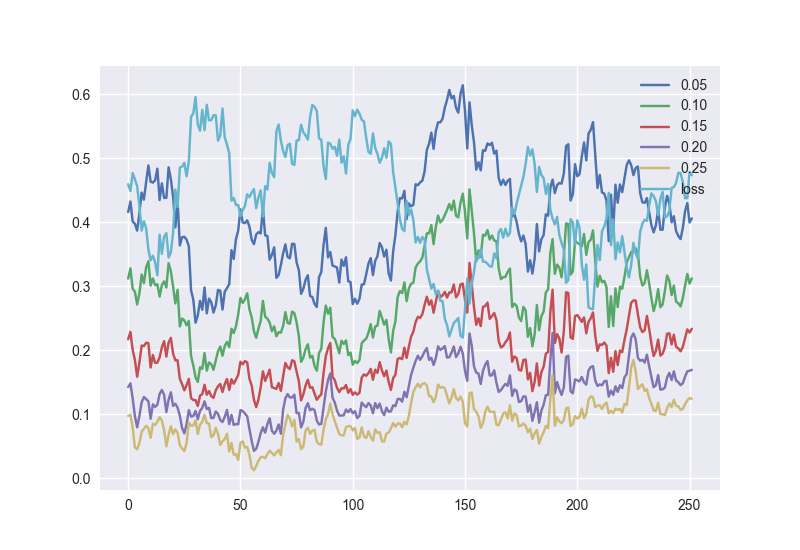

In [196]:
sym='NVDA'
df = pd.DataFrame(web.DataReader(sym, 'yahoo', sd, ed)['Close'])
C=np.hstack( map(lambda x: profitmap3(x,df,63) ,range(2005,2016)))
print C.shape
fig, ax = plt.subplots()
for x in np.linspace(0.05, 0.25,5 ):
    ax.plot(profit_density(C,x,5), label="%0.2f"%x)
ax.plot(profit_density(C,-1,0), label="loss")
plt.legend()
plt.show()

In [208]:
q=np.array(profit_density(C,-1,0))
map(lambda x: int(x), filter(lambda x: q[x] < 0.25, np.nditer(argrelmin(q, order=21))))


[149]

In [198]:


bt= pm_backtest(df,2005,149,1.15,63)
print sum(bt)
bt=map(lambda x: x+1,bt)
reduce(lambda x,y: x*y, bt)


1.59407176306


4.353535628189374

In [190]:
sy=dt.date(2005,1,1)
data = df[sy:]
data.iloc[235]

Close    10.564285
Name: 2005-12-07 00:00:00, dtype: float64

In [ ]:
B=A[:,:100]
fig, ax = plt.subplots()
ax = sns.heatmap(B,xticklabels=5,yticklabels=15)

In [ ]:
def examine_year(year,sym,si,ei):
    sy = dt.date(year,1,1)   
    data = df[sym][sy:]
    a= data.ix[si]
    b= data.ix[si + ei]
    print a,b, b/a, ((b/a) -1) * 100 
    print data.index[si],data.index[si+ei]

eyear = lambda year: examine_year(year,'AKAM',121,34)
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

interact(eyear, year=(2005,2017));

In [ ]:
a=enumerate(df['AAPL'][dt.date(2017,1,1):].index)
[x for x in a]

In [ ]:
np.argmax(A[84, ])
A[84,173]

In [ ]:
i = 122
A = []
sym='TGT'
df = pd.DataFrame(web.DataReader(sym, 'google', sd, ed)['Close'])
for x in range(2005,2016):
    s = df[dt.date(x,1,1):]
    s = s.ix[i:i+122]
    s = s/s.ix[0]
    p = np.array(s/s.ix[0] -1).reshape(122)
    A.append(p)
fig, ax = plt.subplots()
ax.plot(sum(A)/len(range(2005,2016)), label="%0.2f"%x)
plt.legend()
plt.show()
    


In [ ]:
122 + 56